# Simulation II

Here, we will apply and compare a sparse approach with variational inference to GPC ([Hensman et al., 2015](https://arxiv.org/abs/1411.2005)) to a simulated 2-D dataset. We will call this method "SVGP" and compare it with:

1. An approach to GPC with variational inference only (FVGP).
2. An approahc to GPC with Laplace approximations (LGP).
3. Logistc regression (LR).

In [48]:
%pylab inline
import time
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

import pandas as pd
from statsmodels.tools import add_constant
import statsmodels.api as sm
from scipy.special import expit, logit

Populating the interactive namespace from numpy and matplotlib


In [49]:
#PLotting specifications

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['text.usetex'] = True
import matplotlib;matplotlib.rcParams['font.size'] = 16
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

## Setting Up Simulation Data

Here, we will set up our simulated data. 


Our dataset consists of $n=1500$ data points. For compatibility, with matplotlib's plotting functions, we prepared the training and test sets independently. We take a train-test split of $75-25\%$.

As we have two covariates $x_1, x_2$, we draw $m$ random uniform draws for each and store them in a design matrix $X_{test}$ or $X_{train}$. Here, $m=0.75n$ or $m=0.25n$ depeneding on whether we are drawing for the test or training set. These draws are scaled by 21, such that the data points lie in $[0,21)$. 

We then apply the latent function $f$ to $X_{test}$ ($X_{train}$): $$f(x_1,x_2) = \frac{4\sin(x_1+x_2)}{3}$$.

Next, we transform the latent function values $f$ to probabilities via the logistic function.
In order to set up the simulation data, we then random assign classes ($0$ or $1$) to our data. This is done by comparing the probabilities to an array of randomly generated probabilities, and assigning $1$ where the probability is less than the generated probability, and $0$ otherwise.

In order to allow for the SVGP, we also draw inducing points, $Z$, like for $X_{test}$ (or $X_{train}$). <br>
Here, we take the inducing points to be $10\%$ the size of the training set.


**Notes:** 

1. It is okay to prepare the training and test set independently here as the data points are drawn from the same distribution, the latent function is the same and the same procedure is used to transform latent function values into probabilities and assign Bernoulli draws.

2. Some details have been omitted here for brevity, but the general procedure is the same.

In [50]:
np.random.seed(42)     #to make it reproducible

#Function for simulation

def fun(x, y):
    
    return np.sin((x+y)/3)*4

#Drawing inputs and latent function values for training and test set#
#Training and test sets are prepared independently to allow for 3D plotting

#Preparing training set

N = 1500
n_train = int(np.ceil(np.sqrt((0.75*N))))
n_test = int(np.floor(np.sqrt((0.25*N))))

draws = np.random.rand(38,1)*21
order = np.argsort(draws.reshape(38,))
x1 = x2 = draws[order]
X1_train_mat, X2_train_mat = np.meshgrid(x1, x2)
fs = np.array(fun(np.ravel(X1_train_mat), np.ravel(X2_train_mat)))
f_train_mat = fs.reshape(X1_train_mat.shape)

#Drawing classes

p_train_mat = np.exp(f_train_mat)/(1+np.exp(f_train_mat))      #Applying sigmoid function to f to return probabilities
Y_train_mat = np.where(p_train_mat>np.random.rand(*p_train_mat.shape), 1,0)    #assign random classes

#Drawing inducing inputs 

M = int(np.ceil(np.sqrt((0.10*0.75*N))))
Z_draws = np.random.rand(M,1)*21
order = np.argsort(Z_draws.reshape(M,))
z1 = z2 = Z_draws[order]
Z1_mat, Z2_mat = np.meshgrid(z1, z2)

In [51]:
#Preparing test set

draws = np.random.rand(n_test,1)*21
order = np.argsort(draws.reshape(n_test,))
x1 = x2 = draws[order]
X1_test_mat, X2_test_mat = np.meshgrid(x1, x2)
fs = np.array(fun(np.ravel(X1_test_mat), np.ravel(X2_test_mat)))
f_test_mat = fs.reshape(X1_test_mat.shape)

#Drawing classes

p_test_mat = np.exp(f_test_mat)/(1+np.exp(f_test_mat))      #Applying sigmoid function to f to return probabilities
Y_test_mat = np.where(p_test_mat>np.random.rand(*p_test_mat.shape), 1,0)    #assign random classes

In [52]:
#Transforming data to model form

#Training set

X_train = np.column_stack((np.ravel(X1_train_mat), np.ravel(X2_train_mat)))
Y_train = np.ravel(Y_train_mat)
Z = np.column_stack((np.ravel(Z1_mat), np.ravel(Z2_mat)))

f_train = np.ravel(f_train_mat)
p_train = np.ravel(p_train_mat)

#Test set

X_test = np.column_stack((np.ravel(X1_test_mat), np.ravel(X2_test_mat)))
Y_test = np.ravel(Y_test_mat)


f_test = np.ravel(f_test_mat)
p_test = np.ravel(p_test_mat)


In [7]:
print(f"X train: {X_train.shape}, f train:{f_train.shape}, p train: {p_train.shape}\nY train:{Y_train.shape}\n\n")
print(f"X test: {X_test.shape}, f test:{f_test.shape}, p test: {p_test.shape}\nY test:{Y_test.shape}")

X train: (1444, 2), f train:(1444,), p train: (1444,)
Y train:(1444,)


X test: (361, 2), f test:(361,), p test: (361,)
Y test:(361,)


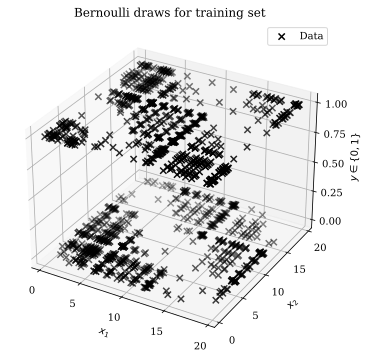

In [13]:
#Plot of data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1_train_mat, X2_train_mat, Y_train_mat, marker= "x", color="black", s=40)
ax.set_title('Bernoulli draws for training set')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y \in \{0,1\}$')
ax.legend( ["Data"], loc="best")

plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.locator_params(axis="z", nbins=5)


plt.savefig("Sim_2_Bernoulli_draws_train", dpi=1000)
plt.show()

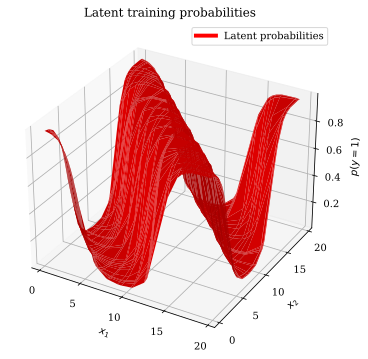

In [14]:
#Plotting latent probabilities

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1_train_mat, X2_train_mat, p_train_mat, color="red")
ax.set_title("Latent training probabilities")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(y=1)$')

plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.locator_params(axis="z", nbins=5)

legend_elements = [Line2D([0], [0], color='red', lw=4, label='Latent probabilities')]
ax.legend(handles=legend_elements, loc="best")

plt.savefig("Sim_2_latent_probs_train", dpi=1000)
plt.show()

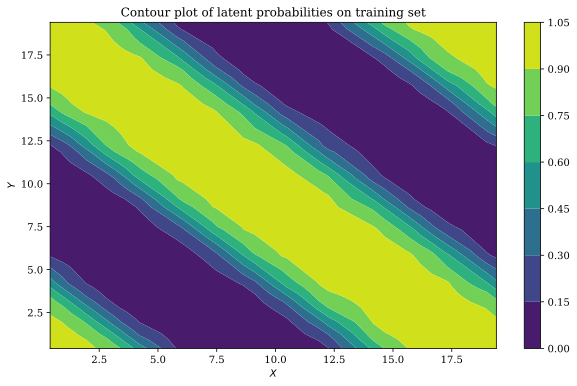

In [12]:
#Plotting latent probabilities contour plot

fig = plt.figure()
ax = fig.add_subplot(111)

cp = ax.contourf(X1_train_mat, X2_train_mat, p_train_mat)
ax.set_title("Contour plot of latent probabilities on training set")
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
fig.colorbar(cp)

plt.savefig("Sim_2_contour_latent_probs_train", dpi=100)
plt.show()

## GP Variational Classification

### SVGP

In [15]:
#Stochastic Variational GP model, with sparse approximations 

Y_train = Y_train.reshape(Y_train.shape[0],1)

m = GPy.core.SVGP(X_train, Y_train, kernel=GPy.kern.RBF(2)+GPy.kern.White(2), likelihood=GPy.likelihoods.Bernoulli(), Z=Z)

In [16]:
#Optimizing model and plotting model probabilities

mean_t = 0
for i in range(5):
    t0 = time.time()
    m.optimize('bfgs')
    t1 = time.time()
    mean_t += t1-t0
    
mean_t = mean_t/5

In [4]:
#Time taken

print(f'Mean time taken for SVGP: {mean_t}')

Mean time taken for SVGP: 122.3648233927553


In [ ]:
#Saving time

comp_times = {"SVGP": 0, "FVGP": 0, "LGP": 0, "LR": 0}
comp_times["SVGP"] = mean_t

In [17]:
#Model output 

m

SVGP.,value,constraints,priors
inducing inputs,"(256, 2)",,
sum.rbf.variance,1.5779276239281483,+ve,
sum.rbf.lengthscale,4.83061525197829,+ve,
sum.white.variance,2.3544937215530395e-08,+ve,
q_u_chol,"(32896, 1)",,
q_u_mean,"(256, 1)",,


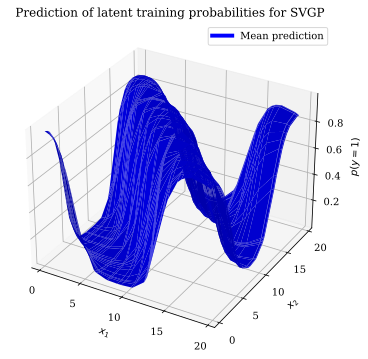

In [18]:
#3D plot of predicted probabilities for training set

#Getting predictions and shaping appropraitely for plotting 

predict_sparse_var = m.predict(X_train)[0]
predict_sparse_var_mat = predict_sparse_var.reshape(X1_train_mat.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1_train_mat, X2_train_mat, predict_sparse_var_mat, color="blue")
ax.set_title("Prediction of latent training probabilities for SVGP")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(y=1)$')

plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.locator_params(axis="z", nbins=5)


legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Mean prediction')]
ax.legend(handles=legend_elements, loc="best")

plt.savefig("Simulation_2_predict_probs_SVGP", dpi=1000)
plt.show()

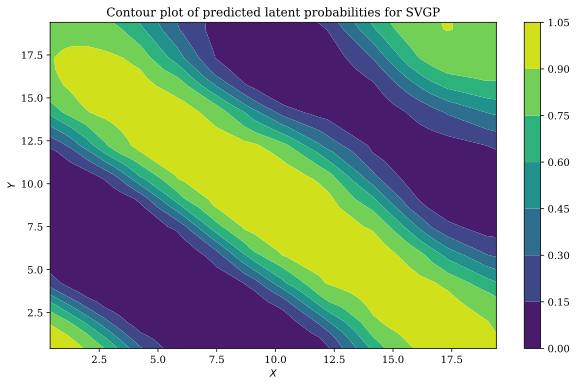

In [62]:
#Plotting predicted latent probabilities contour plot for training set

fig = plt.figure()
ax = fig.add_subplot(111)

cp = ax.contourf(X1_train_mat, X2_train_mat, predict_sparse_var_mat)
ax.set_title("Contour plot of predicted latent probabilities for SVGP")
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
fig.colorbar(cp)

plt.savefig("Simulation_2_contour_predict_probs_SVGP", dpi=100)
plt.show()

In [20]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

Y_test = Y_test.reshape(Y_test.shape[0],1)

predict_sparse_var = m.predict(X_test)[0]
classification_sparse_var = np.where(predict_sparse_var >= 0.5, 1, 0)
CRR_sparse_var = np.where(classification_sparse_var == Y_test)[0].size/Y_test.size    #corect classification rate

In [6]:
#CRR

print(f'CRR for SVGP: {CRR_sparse_var}')

CRR for SVGP: 0.853185595567867


In [22]:
#Saving CRR

CRRs = {"SVGP": 0, "FVGP": 0, "LGP": 0, "LR": 0}
CRRs["SVGP"] = CRR_sparse_var

### FVGP

In [32]:
#Full model, without sparse approximations

m = GPy.models.GPVariationalGaussianApproximation(X_train, Y_train, kernel=GPy.kern.RBF(2)+GPy.kern.White(2), likelihood=GPy.likelihoods.Bernoulli())

In [33]:
#Optimizing model and plotting model probabilities

mean_t = 0
for i in range(5)
    t0 = time.time()
    m.optimize()
    t1 = time.time()
    mean_t += t1-t0
    
mean_t = mean_t/5

In [2]:
#Time taken

print(f'Mean time taken for FVGP: {mean_t}')

Mean time taken for FVGP: 998.4006550312042


In [26]:
#Saving time

comp_times["FVGP"] = mean_t

In [27]:
#Model output 

m

VarGP.,value,constraints,priors
sum.rbf.variance,5.504257015853335,+ve,
sum.rbf.lengthscale,5.0862200778732065,+ve,
sum.white.variance,3.213804589855341e-05,+ve,
alpha,"(1444, 1)",,
beta,"(1444,)",,


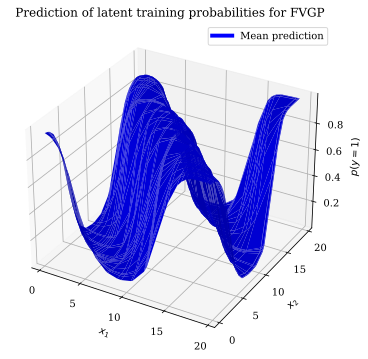

In [34]:
#3D plot of predicted probabilities for training set

#Getting predictions and shaping appropraitely for plotting 

predict_full_var = m.predict(X_train)[0]
predict_full_var_mat = predict_full_var.reshape(X1_train_mat.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1_train_mat, X2_train_mat, predict_full_var_mat, color="blue")
ax.set_title("Prediction of latent training probabilities for FVGP")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(y=1)$')

plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.locator_params(axis="z", nbins=5)

legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Mean prediction')]
ax.legend(handles=legend_elements, loc="best")

plt.savefig("Simulation_2_predict_probs_FVGP", dpi=1000)
plt.show()

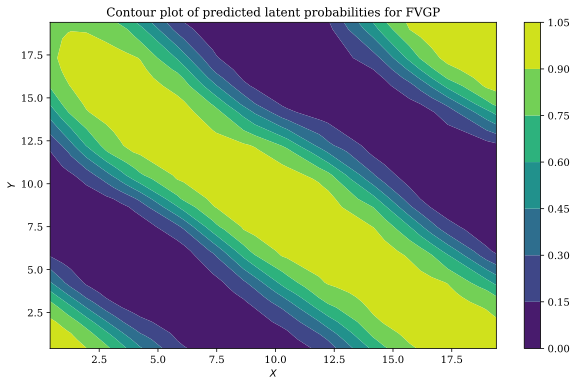

In [29]:
#Plotting predicted latent probabilities contour plot for training set

fig = plt.figure()
ax = fig.add_subplot(111)

cp = ax.contourf(X1_train_mat, X2_train_mat, predict_full_var_mat)
ax.set_title("Contour plot of predicted latent probabilities for FVGP")
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
fig.colorbar(cp)

plt.savefig("Simulation_2_contour_predict_probs_FVGP", dpi=100)
plt.show()

In [30]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

predict_full_var = m.predict(X_test)[0]
classification_full_var = np.where(predict_full_var >= 0.5, 1, 0)
CRR_full_var = np.where(classification_full_var == Y_test)[0].size/Y_test.size    #corect classification rate

In [5]:
#CRR

print(f'CRR for FVGP: {CRR_full_var}')

CRR for FVGP: 0.8881163434903048


In [32]:
#Saving CRR

CRRs["FVGP"] = CRR_full_var

## LGP

In [28]:
#Obtaining probabilities for Laplacian method - uses probit link instead of logit

lik = GPy.likelihoods.Bernoulli()    #Bernoulli likelihood

In [29]:
#Creating Laplacian inference model

kl = GPy.kern.RBF(2, variance=1., lengthscale=1)+GPy.kern.White(2)       #Kernel with specific legnthscale and variance, both set to units
laplace_inf = GPy.inference.latent_function_inference.Laplace()
m = GPy.core.GP(X=X_train,
                Y=Y_train, 
                kernel=kl, 
                inference_method=laplace_inf,
                likelihood=lik)

In [30]:
#Optimizing 

mean_t = 0
for i in range(5):

    t0= time.time()
    m.optimize('bfgs', max_iters=100)
    t1 = time.time()
    mean_t += t1-t0
    
mean_t = mean_t/5

In [7]:
#Time taken

print(f'Mean time taken for LGP: {mean_t}')

Mean time taken for LGP: 140.54333019256592


In [37]:
#Saving time

comp_times["LGP"] = mean_t

In [38]:
#Model output

m

gp.,value,constraints,priors
sum.rbf.variance,4.888398193803126,+ve,
sum.rbf.lengthscale,4.60311505702666,+ve,
sum.white.variance,1.5574155312938495e-06,+ve,


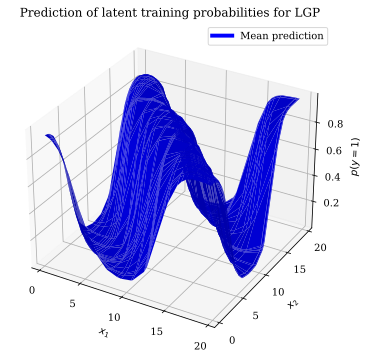

In [31]:
#3D plot of predicted probabilities for training set

#Getting predictions and shaping appropraitely for plotting 

predict_LGP = m.predict(X_train)[0]
predict_LGP_mat = predict_LGP.reshape(X1_train_mat.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1_train_mat, X2_train_mat, predict_LGP_mat, color="blue")
ax.set_title("Prediction of latent training probabilities for LGP")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(y=1)$')

plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.locator_params(axis="z", nbins=5)


legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Mean prediction')]
ax.legend(handles=legend_elements, loc="best")

plt.savefig("Simulation_2_predict_probs_LGP", dpi=1000)
plt.show()

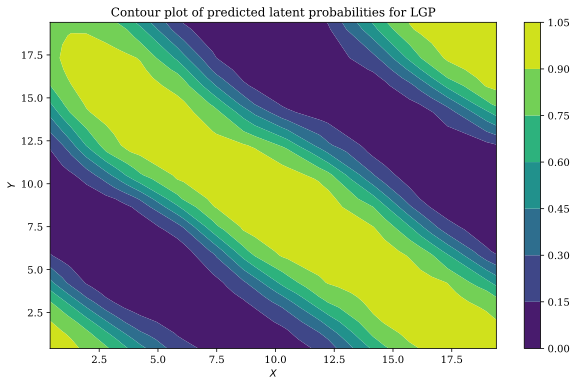

In [40]:
#Plotting predicted latent probabilities contour plot for training set

fig = plt.figure()
ax = fig.add_subplot(111)

cp = ax.contourf(X1_train_mat, X2_train_mat, predict_LGP_mat)
ax.set_title("Contour plot of predicted latent probabilities for LGP")
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
fig.colorbar(cp)

plt.savefig("Simulation_2_contour_predict_probs_LGP", dpi=100)
plt.show()

In [41]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

predict_LGP = m.predict(X_test)[0]
classification_LGP = np.where(predict_LGP >= 0.5, 1, 0)
CRR_LGP = np.where(classification_LGP == Y_test)[0].size/Y_test.size    #corect classification rate

In [9]:
#CRR

print(f'CRR for LGP: {CRR_LGP}')

CRR for LGP: 0.881163434903048


In [43]:
#Saving CRR

CRRs["LGP"] = CRR_LGP

## LR

In [44]:
#Fitting logistic regression model with logit link, including intercept term

X_train_design = add_constant(X_train)
mean_t = 0
for i in range(5):

    t0 = time.time()
    m = sm.Logit(Y_train, X_train_design).fit()
    t1 = time.time()
    mean_t += t1-t0
    
mean_t = mean_t/5

In [45]:
#Time taken

print(f'Mean time taken for LR: {mean_t}')

Mean time taken for LR: 0.0039997100830078125


In [46]:
#Saving time

comp_times["LR"] = mean_t

In [47]:
#Model summary

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1444
Model:                          Logit   Df Residuals:                     1441
Method:                           MLE   Df Model:                            2
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                0.009501
Time:                        14:46:20   Log-Likelihood:                -991.38
converged:                       True   LL-Null:                       -1000.9
Covariance Type:            nonrobust   LLR p-value:                 7.415e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4850      0.126     -3.845      0.000      -0.732      -0.238
x1             0.0302      0.009      3.372      0.001       0.013       0.048
x2             0.0246      0.009      2.755      0.006       0.007       0.042
==============================================================================
"""

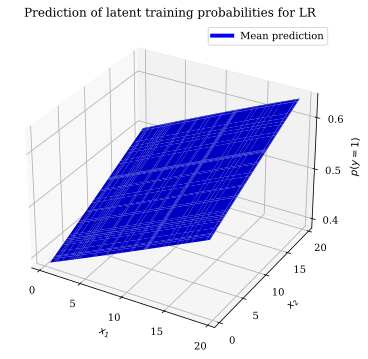

In [26]:
#3D plot of predicted probabilities for training set

#Getting predictions and shaping appropraitely for plotting 

X_train_design = add_constant(X_train)
predict_LR = m.predict(X_train_design).reshape(X_train_design.shape[0],1)
predict_LR_mat = predict_LR.reshape(X1_train_mat.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1_train_mat, X2_train_mat, predict_LR_mat, color="blue")
ax.set_title("Prediction of latent training probabilities for LR")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$p(y=1)$')

plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)
plt.locator_params(axis="z", nbins=5)

legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Mean prediction')]
ax.legend(handles=legend_elements, loc="best")

plt.savefig("Simulation_2_predict_probs_LR", dpi=1000)
plt.show()

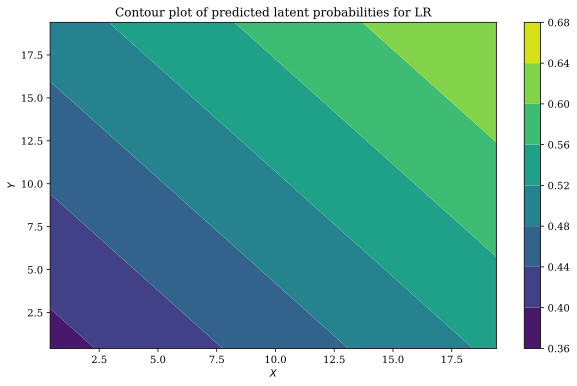

In [49]:
#Plotting predicted latent probabilities contour plot for training set

fig = plt.figure()
ax = fig.add_subplot(111)

cp = ax.contourf(X1_train_mat, X2_train_mat, predict_LR_mat)
ax.set_title("Contour plot of predicted latent probabilities for LR")
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
fig.colorbar(cp)

plt.savefig("Simulation_2_contour_predict_probs_LR", dpi=100)
plt.show()

In [50]:
#Prediction from sparse variational model
#Classification bsaed on threshold of 0.5

X_test_design = add_constant(X_test)
predict_LR = m.predict(X_test_design).reshape(X_test_design.shape[0],1)

classification_LR = np.where(predict_LR >= 0.5, 1, 0)
CRR_LR = np.where(classification_LR == Y_test)[0].size/Y_test.size    #corect classification rate

In [46]:
#CRR

print(f'CRR for LR: {CRR_LR}')

CRR for LR: 0.518005540166205


In [52]:
#Saving CRR

CRRs["LR"] = CRR_LR